# Import

In [1]:
import pandas as pd
import seaborn as sns
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt
from sklearn import metrics, cluster, manifold, decomposition
from ipywidgets import interact, interact_manual
from sklearn.pipeline import Pipeline
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import sys
sys.path.append('./src')

from src.analyze import *

[nltk_data] Downloading package swadesh to
[nltk_data]     C:\Users\saumi\AppData\Roaming\nltk_data...
[nltk_data]   Package swadesh is already up-to-date!


## Import translation data and list of languages with families

In [2]:
data = pd.read_csv('./data/data-latin.csv', index_col=0).fillna('')

languages = pd.read_csv('./data/languages.csv', index_col=0)

languages.loc['major_family'] = languages.loc['family'].apply(lambda x: x.split(',')[0])
languages.loc['sub_family'] = languages.loc['family'].apply(lambda x: x.split(',')[1] if x.split(',')[0]=='Indo-European' else x.split(',')[0])

# Visualize known families

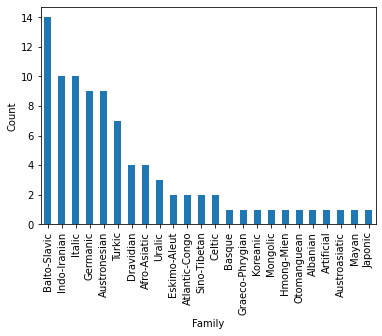

In [3]:
labels = languages.loc['name'].T.to_frame()
labels['family'] = languages.loc['sub_family']

labels['family'].value_counts().plot(kind='bar')
plt.xticks(rotation=90);
plt.ylabel('Count')
plt.xlabel('Family');

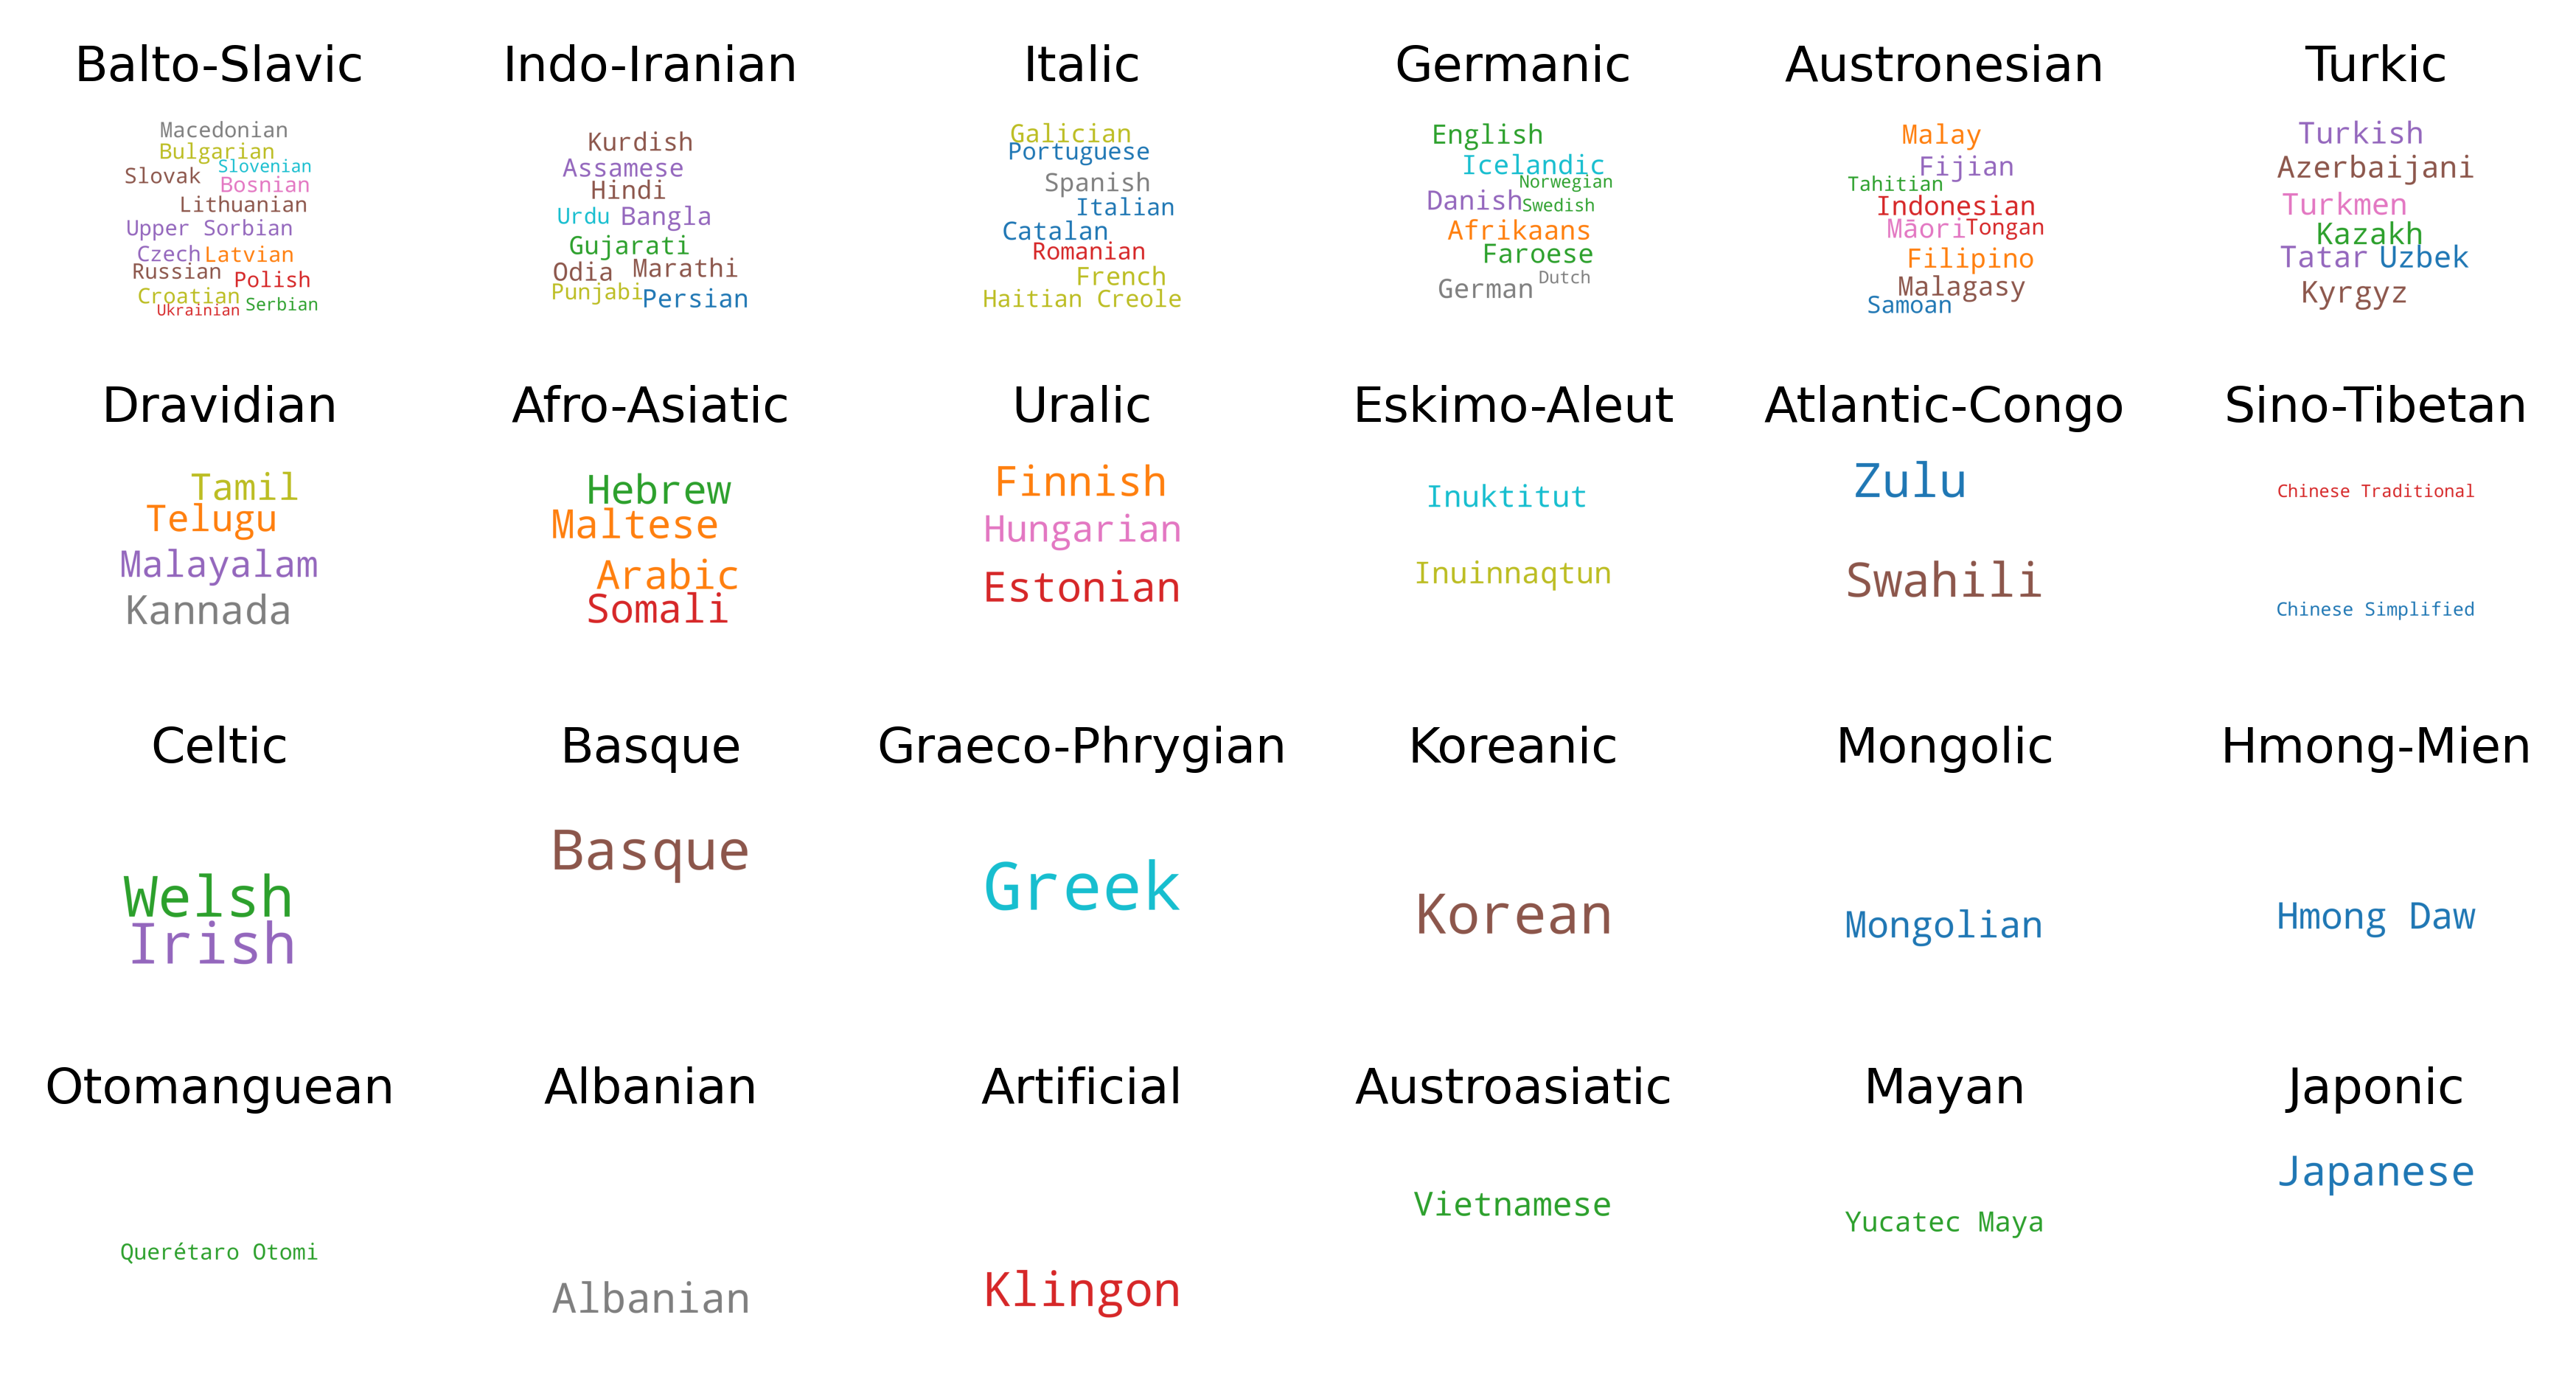

In [4]:
fig = plot_language_groups(labels);

# Analysis on distances from english

In [7]:
#Get distances from english
distances_from_english = data.T.apply(lambda x: dist_to_word(x, x.name))

## PCA followed by k-means clustering

### Grid search over number of components and number of clusters

In [8]:
pca = decomposition.PCA()
X = pca.fit_transform(distances_from_english)

results = []

for n_clusters in [12, 16, 18, 20, 22, 24, 30]:
    for n_components in [10, 20, 30, 40, 80]:

        print("="*100)
        
        print('Number of PCA components = {}, Number of KMeans clusters = {}'.format(n_components, n_clusters))

        kmeans = cluster.KMeans(n_clusters=n_clusters, n_init=200)

        kmeans.fit(X[:, :n_components])

        scores = score_model(kmeans.labels_, languages.loc['sub_family'])

        d = {'n_components':n_components, 'n_clusters':n_clusters}
        d.update(scores)

        results.append(d)

results = pd.DataFrame(results)

Number of PCA components = 10, Number of KMeans clusters = 12
Number of PCA components = 20, Number of KMeans clusters = 12
Number of PCA components = 30, Number of KMeans clusters = 12
Number of PCA components = 40, Number of KMeans clusters = 12
Number of PCA components = 80, Number of KMeans clusters = 12
Number of PCA components = 10, Number of KMeans clusters = 16
Number of PCA components = 20, Number of KMeans clusters = 16
Number of PCA components = 30, Number of KMeans clusters = 16
Number of PCA components = 40, Number of KMeans clusters = 16
Number of PCA components = 80, Number of KMeans clusters = 16
Number of PCA components = 10, Number of KMeans clusters = 18
Number of PCA components = 20, Number of KMeans clusters = 18
Number of PCA components = 30, Number of KMeans clusters = 18
Number of PCA components = 40, Number of KMeans clusters = 18
Number of PCA components = 80, Number of KMeans clusters = 18
Number of PCA components = 10, Number of KMeans clusters = 20
Number o

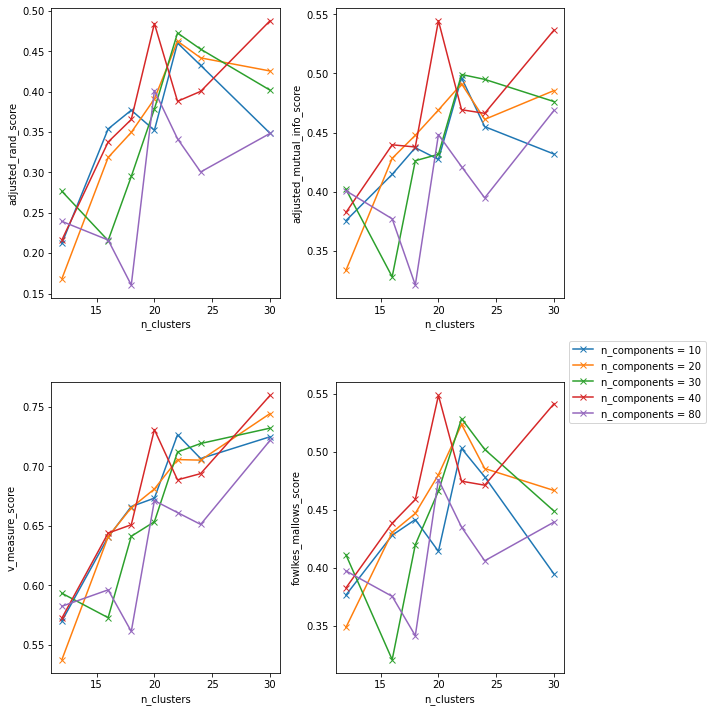

In [9]:
group = results.groupby(['n_components'])

score_name = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'fowlkes_mallows_score']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, name in enumerate(score_name):
    for key, df in group:
        ax[i//2, i%2].plot(df['n_clusters'], df[name], label='n_components = {}'.format(key), marker='x')
    
    ax[i//2, i%2].set_xlabel('n_clusters')
    ax[i//2, i%2].set_ylabel(name)

plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    
plt.tight_layout()

Around 20-40 components with around 20 clusters is optimal

### Visualize the groups for the best fit

num components = 40.0, num clusters = 30.0


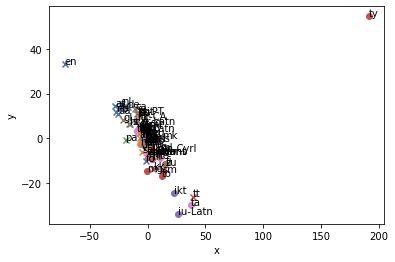

In [10]:
best_params = results.iloc[results['adjusted_rand_score'].argmax()]

print('num components = {}, num clusters = {}'.format(best_params['n_components'], best_params['n_clusters']))

kmeans = cluster.KMeans(n_clusters=int(best_params['n_clusters']), n_init=200)

kmeans.fit(X[:, :int(best_params['n_components'])])

x, y = X[:, :2].T

plot_languages(x, y, labels=languages.loc['sub_family'], languages=languages.columns);

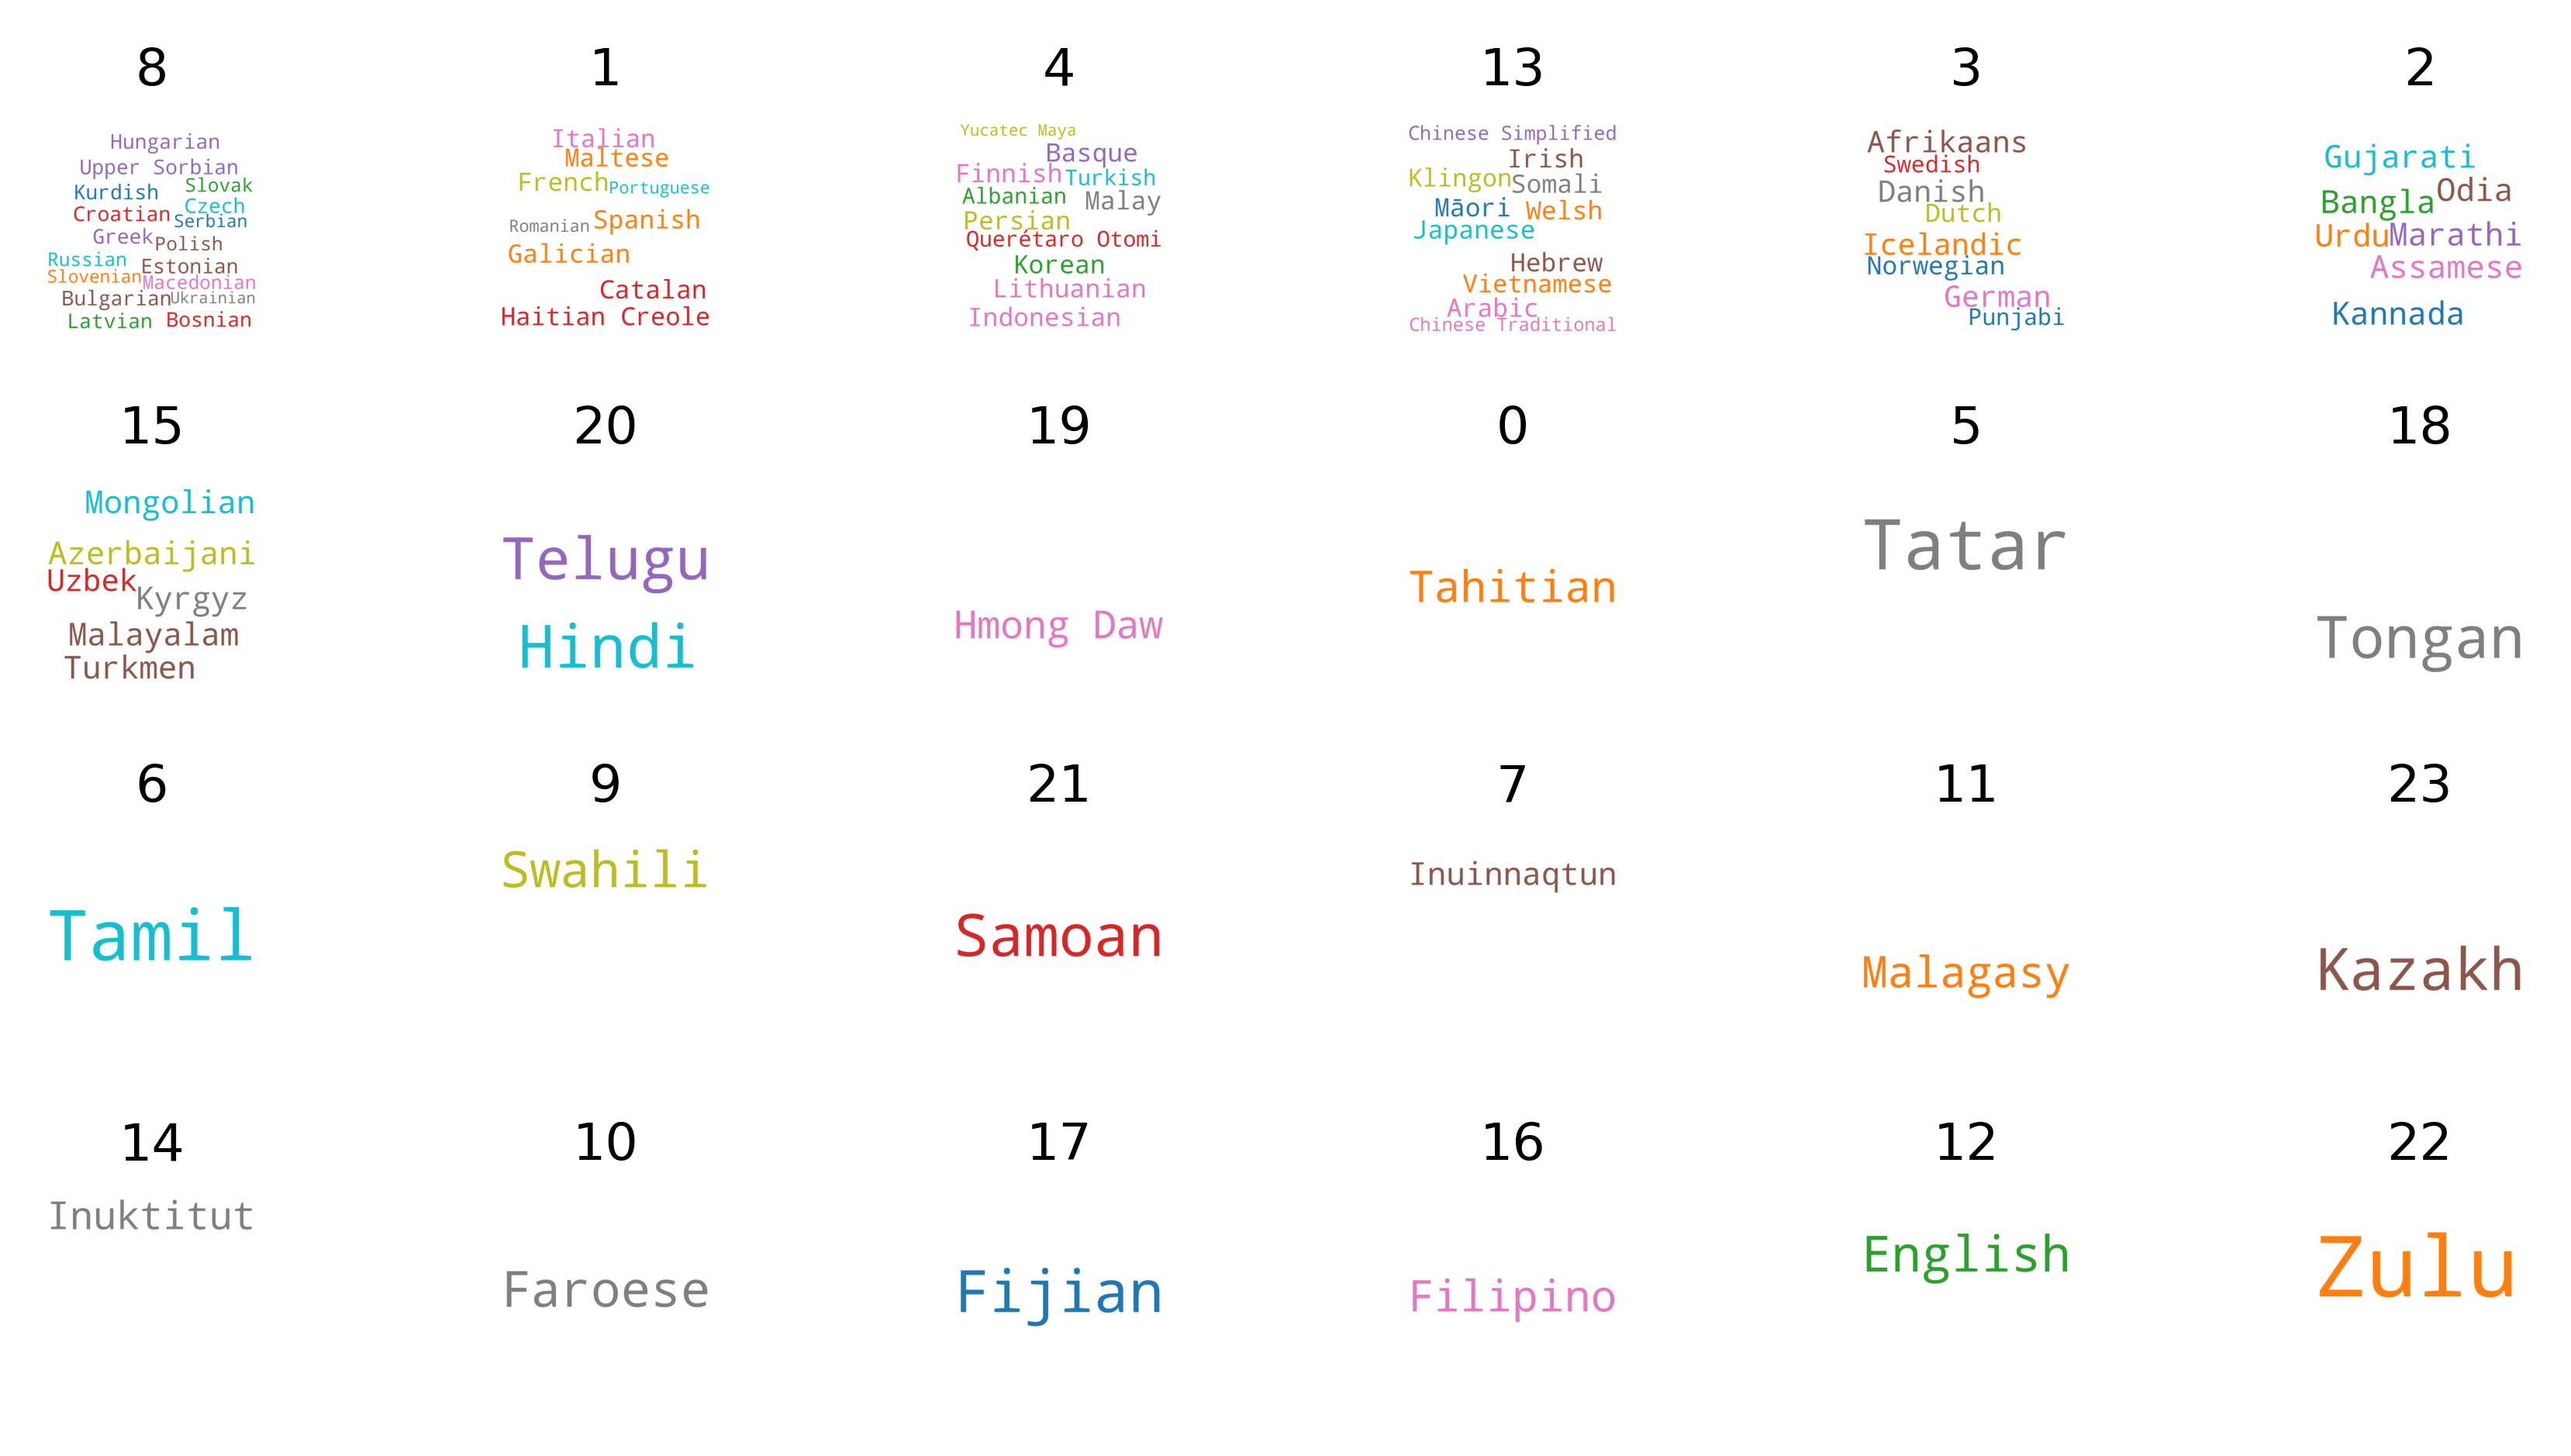

In [10]:
labels = pd.DataFrame({'name':languages.loc['name'], 'family':kmeans.labels_})

plot_language_groups(labels);

We do well with the Balto-Slavic, Italian, Germanic, and Indo-Iranian languages. Not good enough for the rest

## Kernel PCA foolowed by KMeans

### Grid search over number of components and number of clusters

In [52]:
results = []

for gamma in [0.0002, 0.0006, 0.001, 0.004]:
    for n_clusters in [16, 18, 20, 22, 24, 30, 40]:

        kpca = decomposition.KernelPCA(n_components=30, kernel='rbf', gamma=gamma)
        X = kpca.fit_transform(distances_from_english)

        print("="*100)
        
        print('Gamma = {}, Number of KMeans clusters = {}'.format(gamma, n_clusters))

        kmeans = cluster.KMeans(n_clusters=n_clusters, n_init=200)

        kmeans.fit(X)

        scores = score_model(kmeans.labels_, languages.loc['sub_family'])

        d = {'gamma':gamma, 'n_clusters':n_clusters}
        d.update(scores)

        results.append(d)

results = pd.DataFrame(results)

Gamma = 0.0002, Number of KMeans clusters = 16
Gamma = 0.0002, Number of KMeans clusters = 18
Gamma = 0.0002, Number of KMeans clusters = 20
Gamma = 0.0002, Number of KMeans clusters = 22
Gamma = 0.0002, Number of KMeans clusters = 24
Gamma = 0.0002, Number of KMeans clusters = 30
Gamma = 0.0002, Number of KMeans clusters = 40
Gamma = 0.0006, Number of KMeans clusters = 16
Gamma = 0.0006, Number of KMeans clusters = 18
Gamma = 0.0006, Number of KMeans clusters = 20
Gamma = 0.0006, Number of KMeans clusters = 22
Gamma = 0.0006, Number of KMeans clusters = 24
Gamma = 0.0006, Number of KMeans clusters = 30
Gamma = 0.0006, Number of KMeans clusters = 40
Gamma = 0.001, Number of KMeans clusters = 16
Gamma = 0.001, Number of KMeans clusters = 18
Gamma = 0.001, Number of KMeans clusters = 20
Gamma = 0.001, Number of KMeans clusters = 22
Gamma = 0.001, Number of KMeans clusters = 24
Gamma = 0.001, Number of KMeans clusters = 30
Gamma = 0.001, Number of KMeans clusters = 40
Gamma = 0.004, Numbe

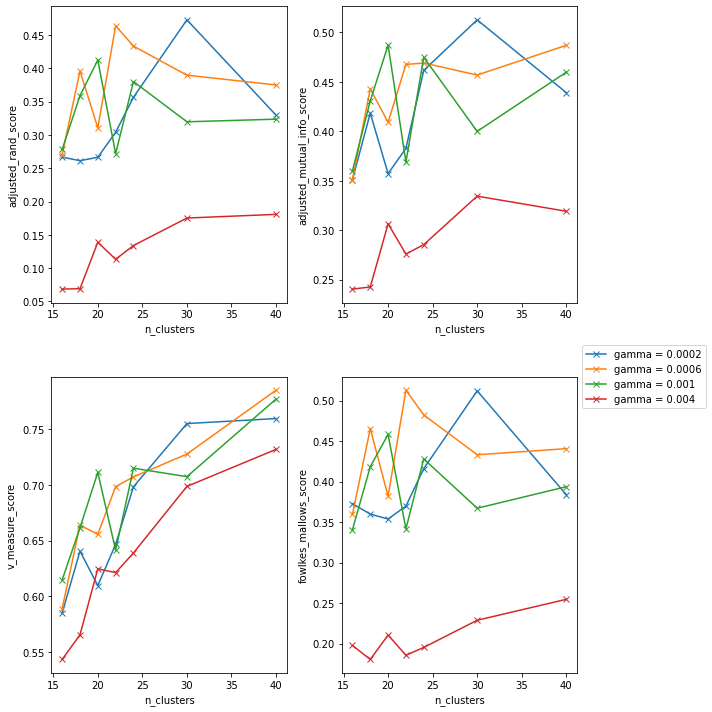

In [53]:
group = results.groupby(['gamma'])

score_name = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'fowlkes_mallows_score']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, name in enumerate(score_name):
    for key, df in group:
        ax[i//2, i%2].plot(df['n_clusters'], df[name], label='gamma = {}'.format(key), marker='x')
    
    ax[i//2, i%2].set_xlabel('n_clusters')
    ax[i//2, i%2].set_ylabel(name)

plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    
plt.tight_layout()

The results are not better than using PCA

## PCA Followed by Mean shift

Most other methods use pairwise distances so it's better to work without computing distance to english

In [26]:
pca = decomposition.PCA()
X = pca.fit_transform(distances_from_english)

results = []

for bw in [5, 10, 12, 14, 16, 18, 20, 25, 30]:
    for n_components in [20, 30, 40]:

        print("="*100)
        
        print('Number of PCA components = {}, Bandwidth = {}'.format(n_components, bw))

        ms = cluster.MeanShift(bandwidth=bw)

        ms.fit(X[:, :n_components])

        scores = score_model(ms.labels_, languages.loc['sub_family'])

        d = {'n_components':n_components, 'bandwidth':bw}
        d.update(scores)

        results.append(d)

results = pd.DataFrame(results)

Number of PCA components = 20, Bandwidth = 5
Number of PCA components = 30, Bandwidth = 5
Number of PCA components = 40, Bandwidth = 5
Number of PCA components = 20, Bandwidth = 10
Number of PCA components = 30, Bandwidth = 10
Number of PCA components = 40, Bandwidth = 10
Number of PCA components = 20, Bandwidth = 12
Number of PCA components = 30, Bandwidth = 12
Number of PCA components = 40, Bandwidth = 12
Number of PCA components = 20, Bandwidth = 14
Number of PCA components = 30, Bandwidth = 14
Number of PCA components = 40, Bandwidth = 14
Number of PCA components = 20, Bandwidth = 16
Number of PCA components = 30, Bandwidth = 16
Number of PCA components = 40, Bandwidth = 16
Number of PCA components = 20, Bandwidth = 18
Number of PCA components = 30, Bandwidth = 18
Number of PCA components = 40, Bandwidth = 18
Number of PCA components = 20, Bandwidth = 20
Number of PCA components = 30, Bandwidth = 20
Number of PCA components = 40, Bandwidth = 20
Number of PCA components = 20, Bandwi

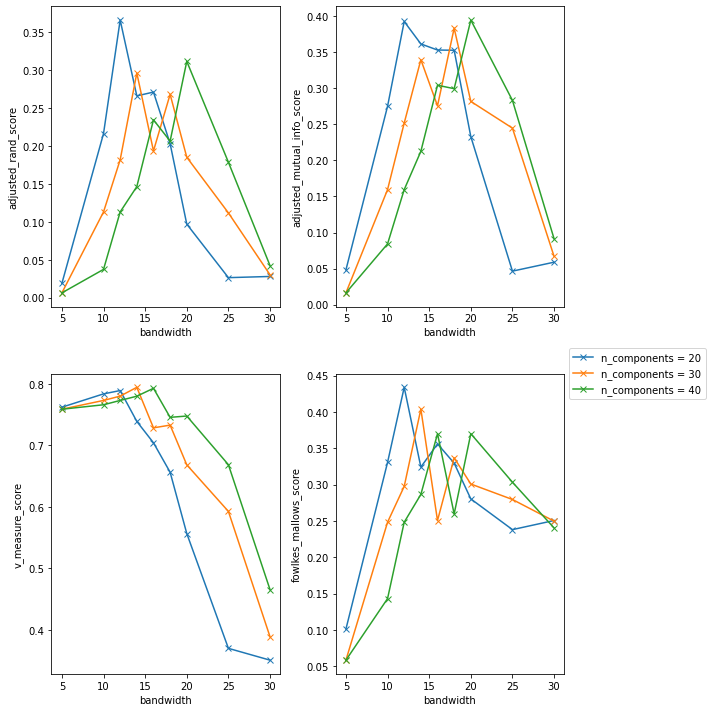

In [27]:
group = results.groupby(['n_components'])

score_name = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'fowlkes_mallows_score']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, name in enumerate(score_name):
    for key, df in group:
        ax[i//2, i%2].plot(df['bandwidth'], df[name], label='n_components = {}'.format(key), marker='x')
    
    ax[i//2, i%2].set_xlabel('bandwidth')
    ax[i//2, i%2].set_ylabel(name)

plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    
plt.tight_layout()

Does not perform better than PCA->KMeans

# Analysis using pairwise distances

In [11]:
pw_dist_data = pairwise_word_distances(data)

## For a single word

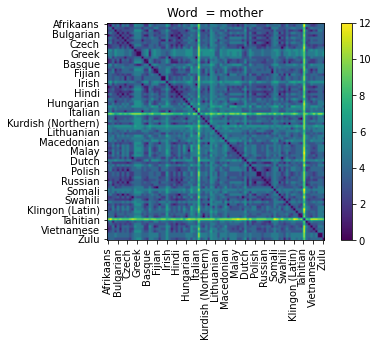

In [12]:
word = 'mother'

d = pw_dist_data.loc[word]

plt.imshow(d)
plt.title('Word  = {}'.format(word))
plt.colorbar()

delta = 4

plt.xticks(np.arange(0, len(languages.columns), delta), languages.loc['name'].iloc[::delta], rotation=90);
plt.yticks(np.arange(0, len(languages.columns), delta), languages.loc['name'].iloc[::delta]);

## Distance for all words

In [13]:
@interact
def plot_p_norm_distance(p=(0.1, 4, 0.1)):
    d = (pw_dist_data.apply(lambda x: x**p).sum()**(1/p))
    d = d/d.max()
    plt.imshow(d)
    plt.colorbar()

    delta = 4
    plt.xticks(np.arange(0, len(languages.columns), delta), languages.loc['name'].iloc[::delta], rotation=90);
    plt.yticks(np.arange(0, len(languages.columns), delta), languages.loc['name'].iloc[::delta]);

    plt.title('Normalized {} norm distance for all words'.format(p));

interactive(children=(FloatSlider(value=2.0, description='p', max=4.0, min=0.1), Output()), _dom_classes=('wid…

Clustering techniques suited for the task:
* Affinity propagation - Good for many clusters and uneven cluster size
* Hierarchical clustering - Good for many clusters, can view tree
* OPTICS - uneven cluster size and density

## Affinity propagation

In [9]:
results = []

for l in [1, 1.5, 2]:
    #Get l-norm distances
    X = pw_dist_data.apply(lambda x: x**l).sum()**(1/l)
    X = X/X.max()
    #Convert distance to similarity
    X = np.exp(- X / X.std())

    for damping in [0.5, 0.6, 0.7, 0.8, 0.9]:

        print("="*100)
        
        print('Norm = {}, Damping = {}'.format(l, damping))

        afp = cluster.AffinityPropagation(damping=damping, affinity='precomputed')
        afp.fit(X)

        scores = score_model(afp.labels_, languages.loc['sub_family'])

        d = {'norm':l, 'damping':damping}
        d.update(scores)

        results.append(d)

results = pd.DataFrame(results)


Norm = 1, Damping = 0.5
Norm = 1, Damping = 0.6
Norm = 1, Damping = 0.7
Norm = 1, Damping = 0.8
Norm = 1, Damping = 0.9
Norm = 1.5, Damping = 0.5
Norm = 1.5, Damping = 0.6
Norm = 1.5, Damping = 0.7
Norm = 1.5, Damping = 0.8
Norm = 1.5, Damping = 0.9
Norm = 2, Damping = 0.5
Norm = 2, Damping = 0.6
Norm = 2, Damping = 0.7
Norm = 2, Damping = 0.8
Norm = 2, Damping = 0.9


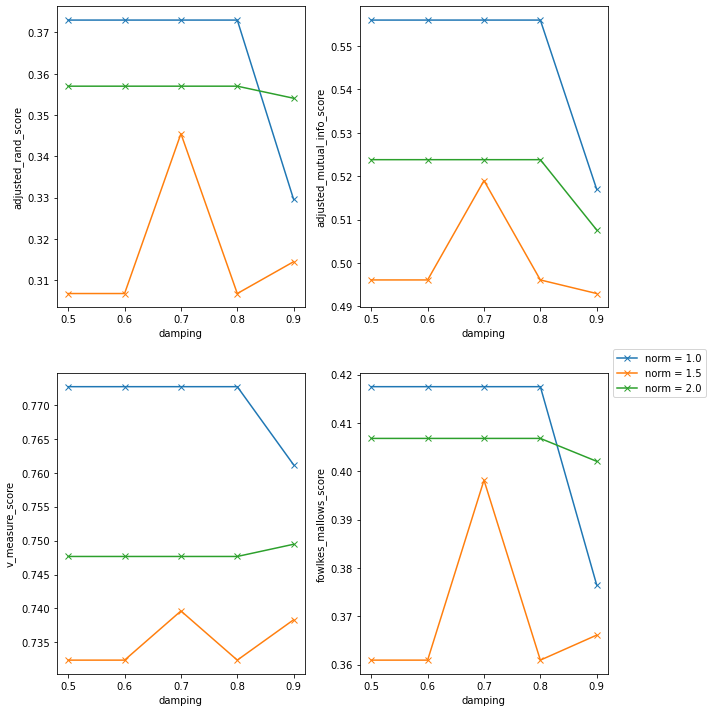

In [10]:
group = results.groupby(['norm'])

score_name = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'fowlkes_mallows_score']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, name in enumerate(score_name):
    for key, df in group:
        ax[i//2, i%2].plot(df['damping'], df[name], label='norm = {}'.format(key), marker='x')
    
    ax[i//2, i%2].set_xlabel('damping')
    ax[i//2, i%2].set_ylabel(name)

plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    
plt.tight_layout()

norm = 1.0, damping = 0.5


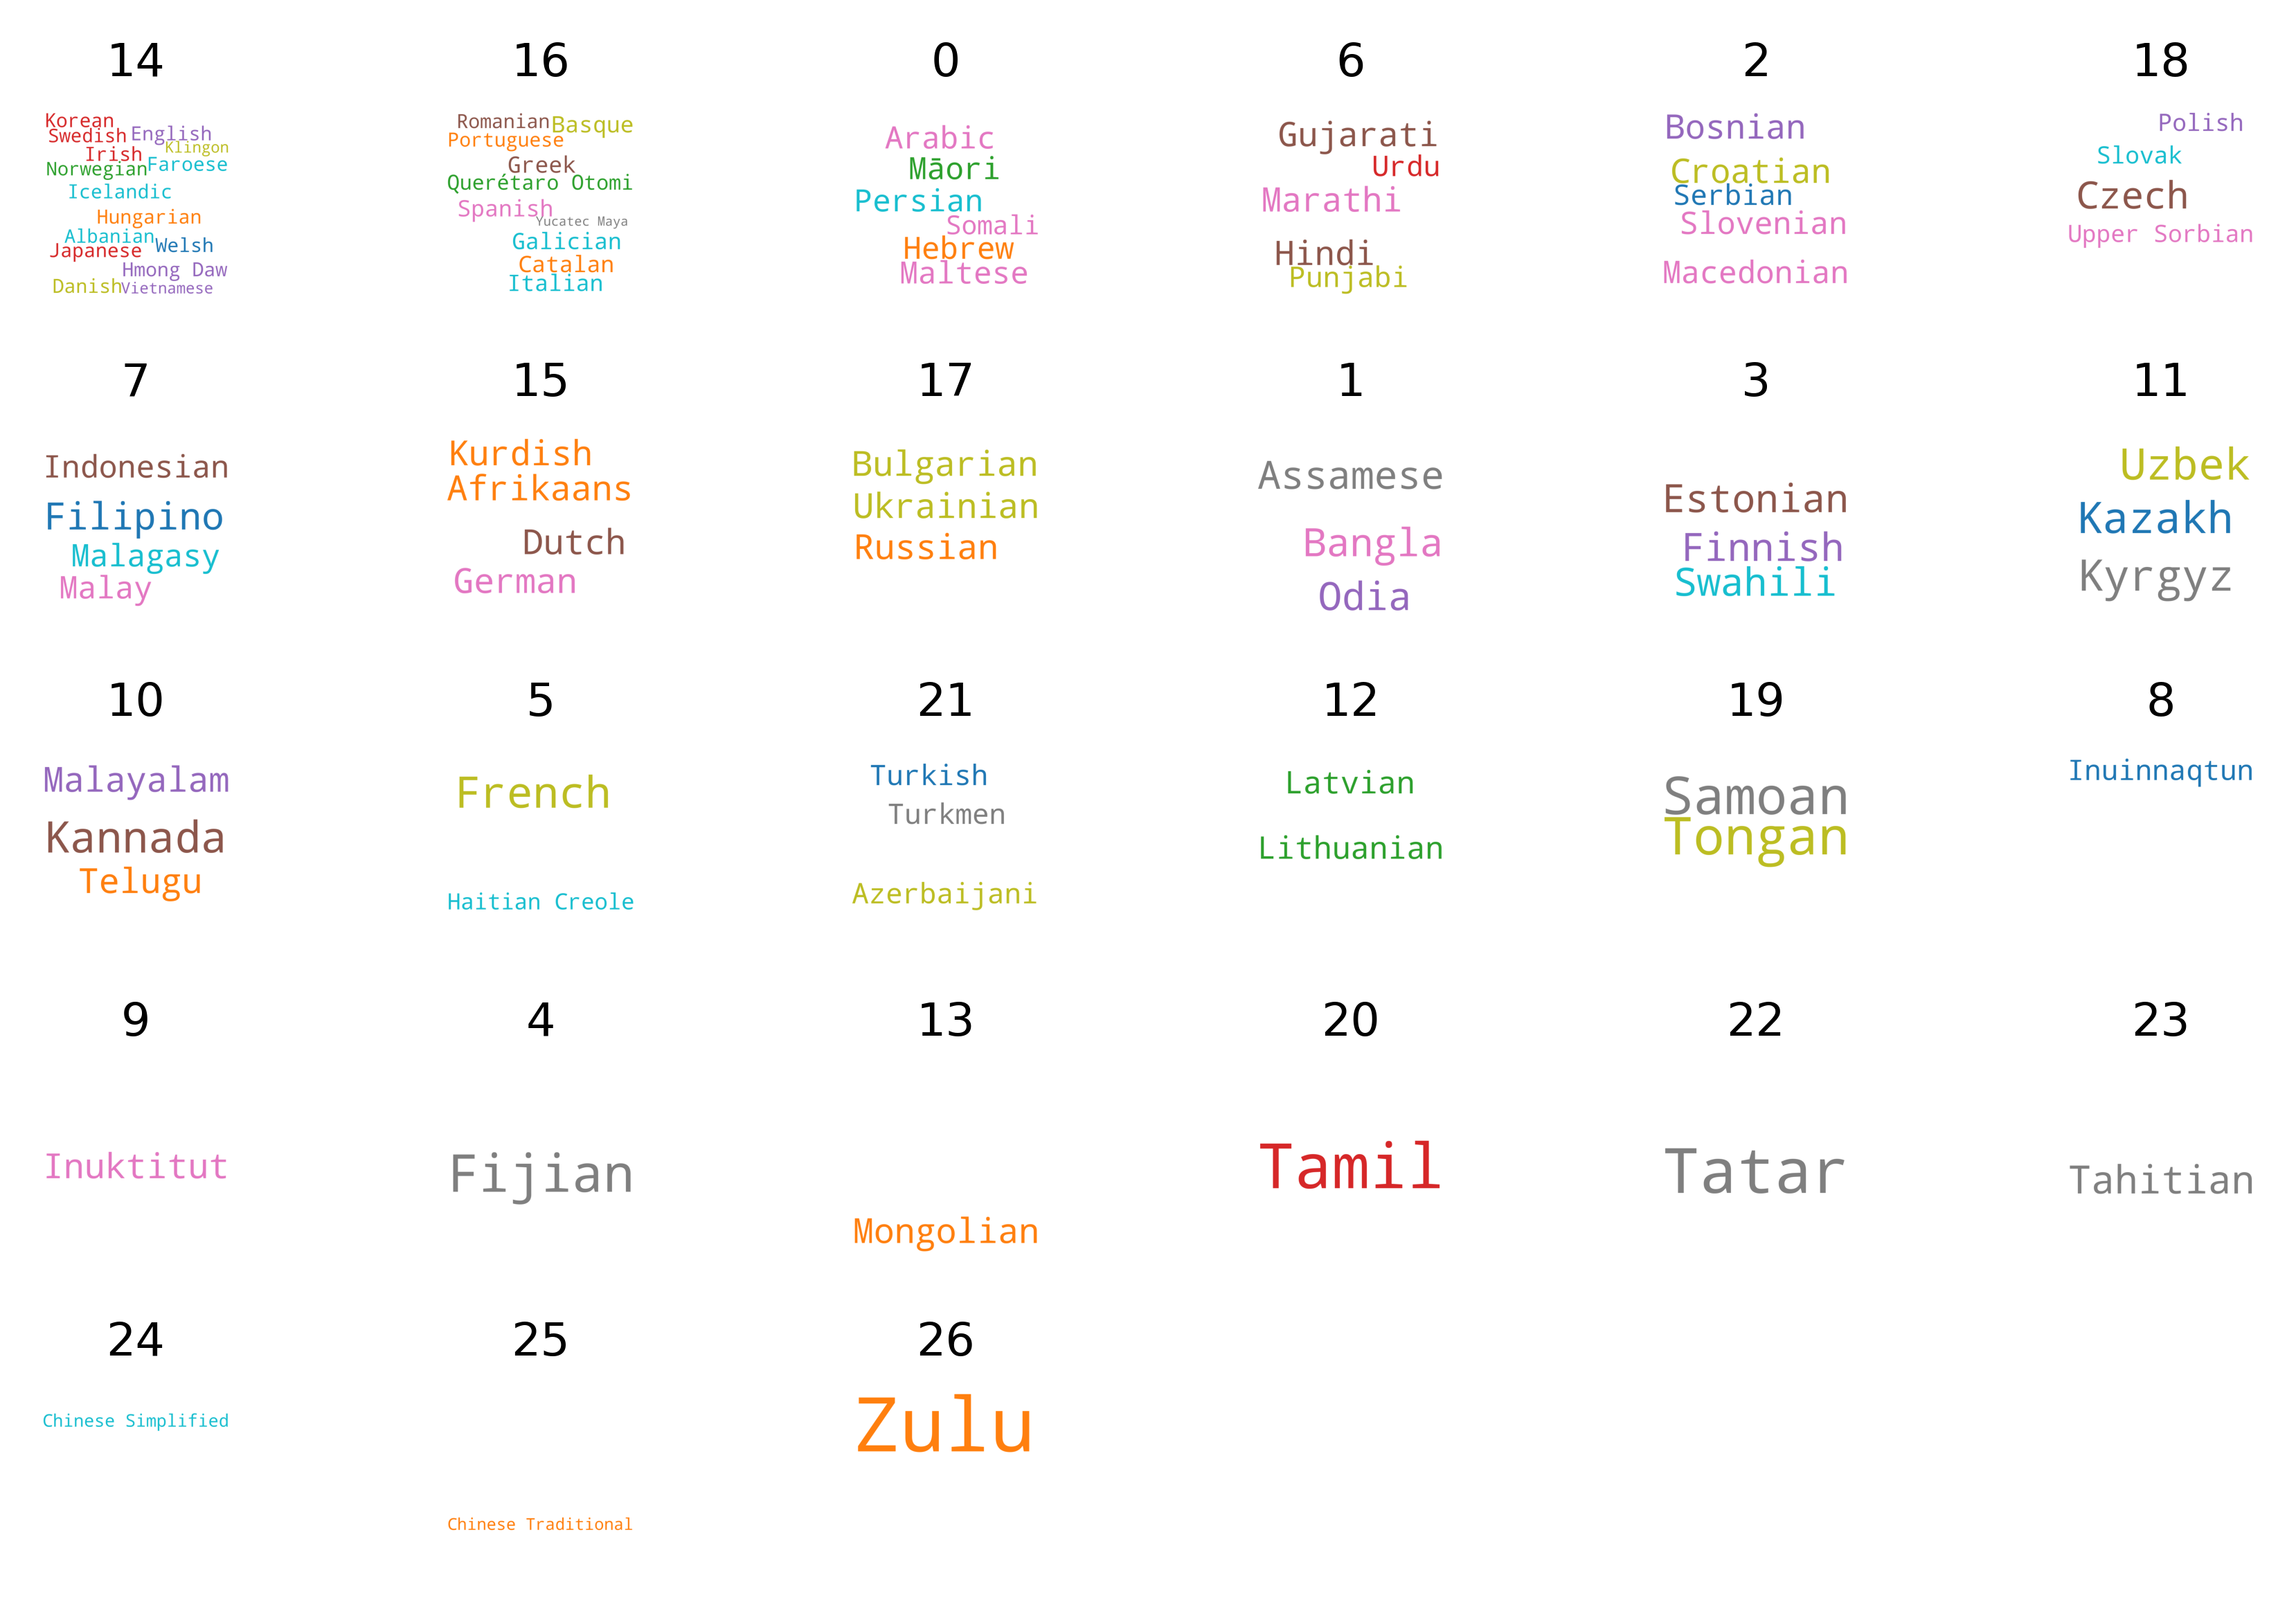

In [11]:
best_params = results.iloc[results['adjusted_mutual_info_score'].argmax()]

print('norm = {}, damping = {}'.format(best_params['norm'], best_params['damping']))

X = pw_dist_data.apply(lambda x: x**best_params['norm']).sum()**(1/best_params['norm'])
X = X/X.max()
#Convert distance to similarity
X = np.exp(- X / X.std())

afp = cluster.AffinityPropagation(damping=damping, affinity='precomputed')

afp.fit(X)

labels = pd.DataFrame({'name':languages.loc['name'], 'family':afp.labels_})

plot_language_groups(labels);

Performs much better on the smaller groups, but slightly worse on the larger groups as it seems to split them further

## Hierarchical clustering

In [14]:
X = (pw_dist_data.sum())
X = X/X.max()
X = sp.spatial.distance.squareform(X)

n_clusters = 24

results = []

for link in ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']:
    
    Z = linkage(X, method=link)

    scores = score_model(fcluster(Z, n_clusters, criterion='maxclust'), languages.loc['sub_family'])

    d = {'linkage':link}
    d.update(scores)
    results.append(d)

pd.DataFrame(results)

,linkage,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score,fowlkes_mallows_score
0,single,0.079735,0.235764,0.768138,0.383726,0.511787,0.308971
1,complete,0.661057,0.719819,0.857205,0.841459,0.849259,0.689343
2,average,0.170081,0.427784,0.825476,0.551417,0.661172,0.366043
3,weighted,0.287994,0.535323,0.825107,0.661301,0.734178,0.424378
4,centroid,0.061376,0.167321,0.696299,0.362664,0.476924,0.280462
5,median,0.042369,0.111826,0.666503,0.293932,0.407954,0.270178
6,ward,0.736464,0.758925,0.856421,0.895279,0.875419,0.757978


Ward linkage performs quite well! (Also complete linkage)

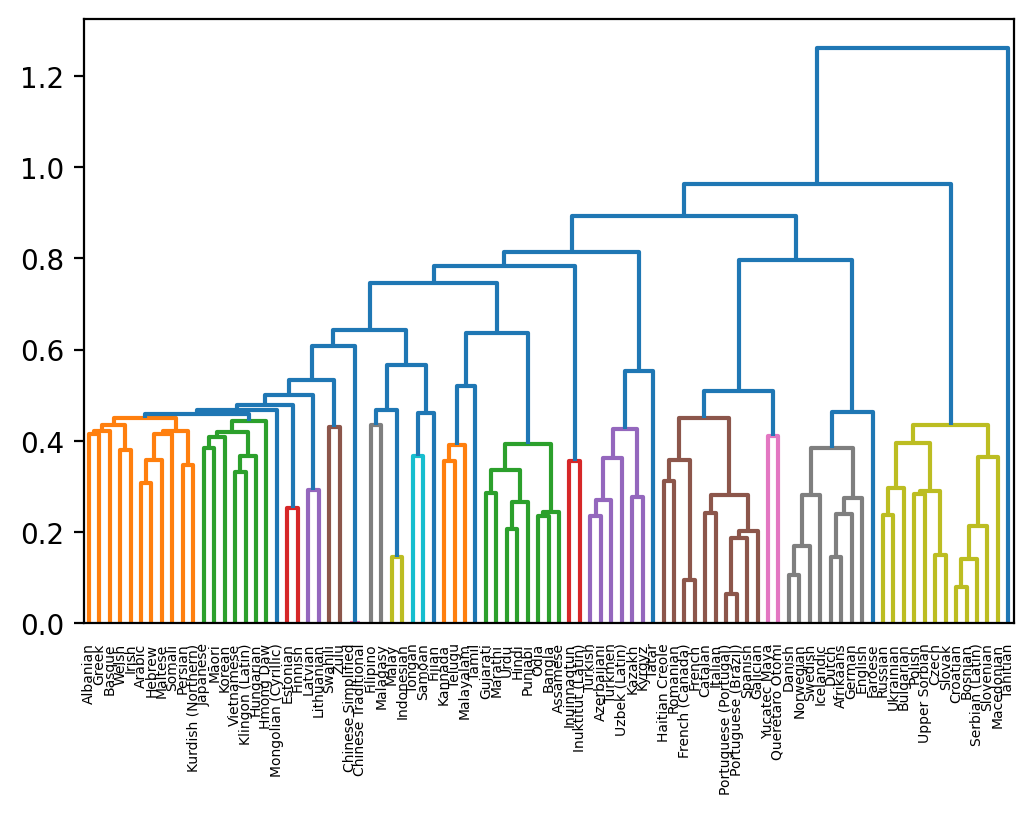

In [15]:
Z = linkage(X, method='ward', optimal_ordering=True)

#Plot tree
fig, ax = plt.subplots(dpi=200)
dendrogram(Z, labels=languages.loc['name'], color_threshold=0.45, ax=ax, distance_sort='descending');

### While this performs relatively well in grouping the most similar languages near each other, we find that in many cases, the distance between successive cluster merges is quite small. We want larger inter-cluster distance to argue for a certain number of clusters. This suggests that we need to try and reduce the distance between similar languages (say by being more selective with the words we use)

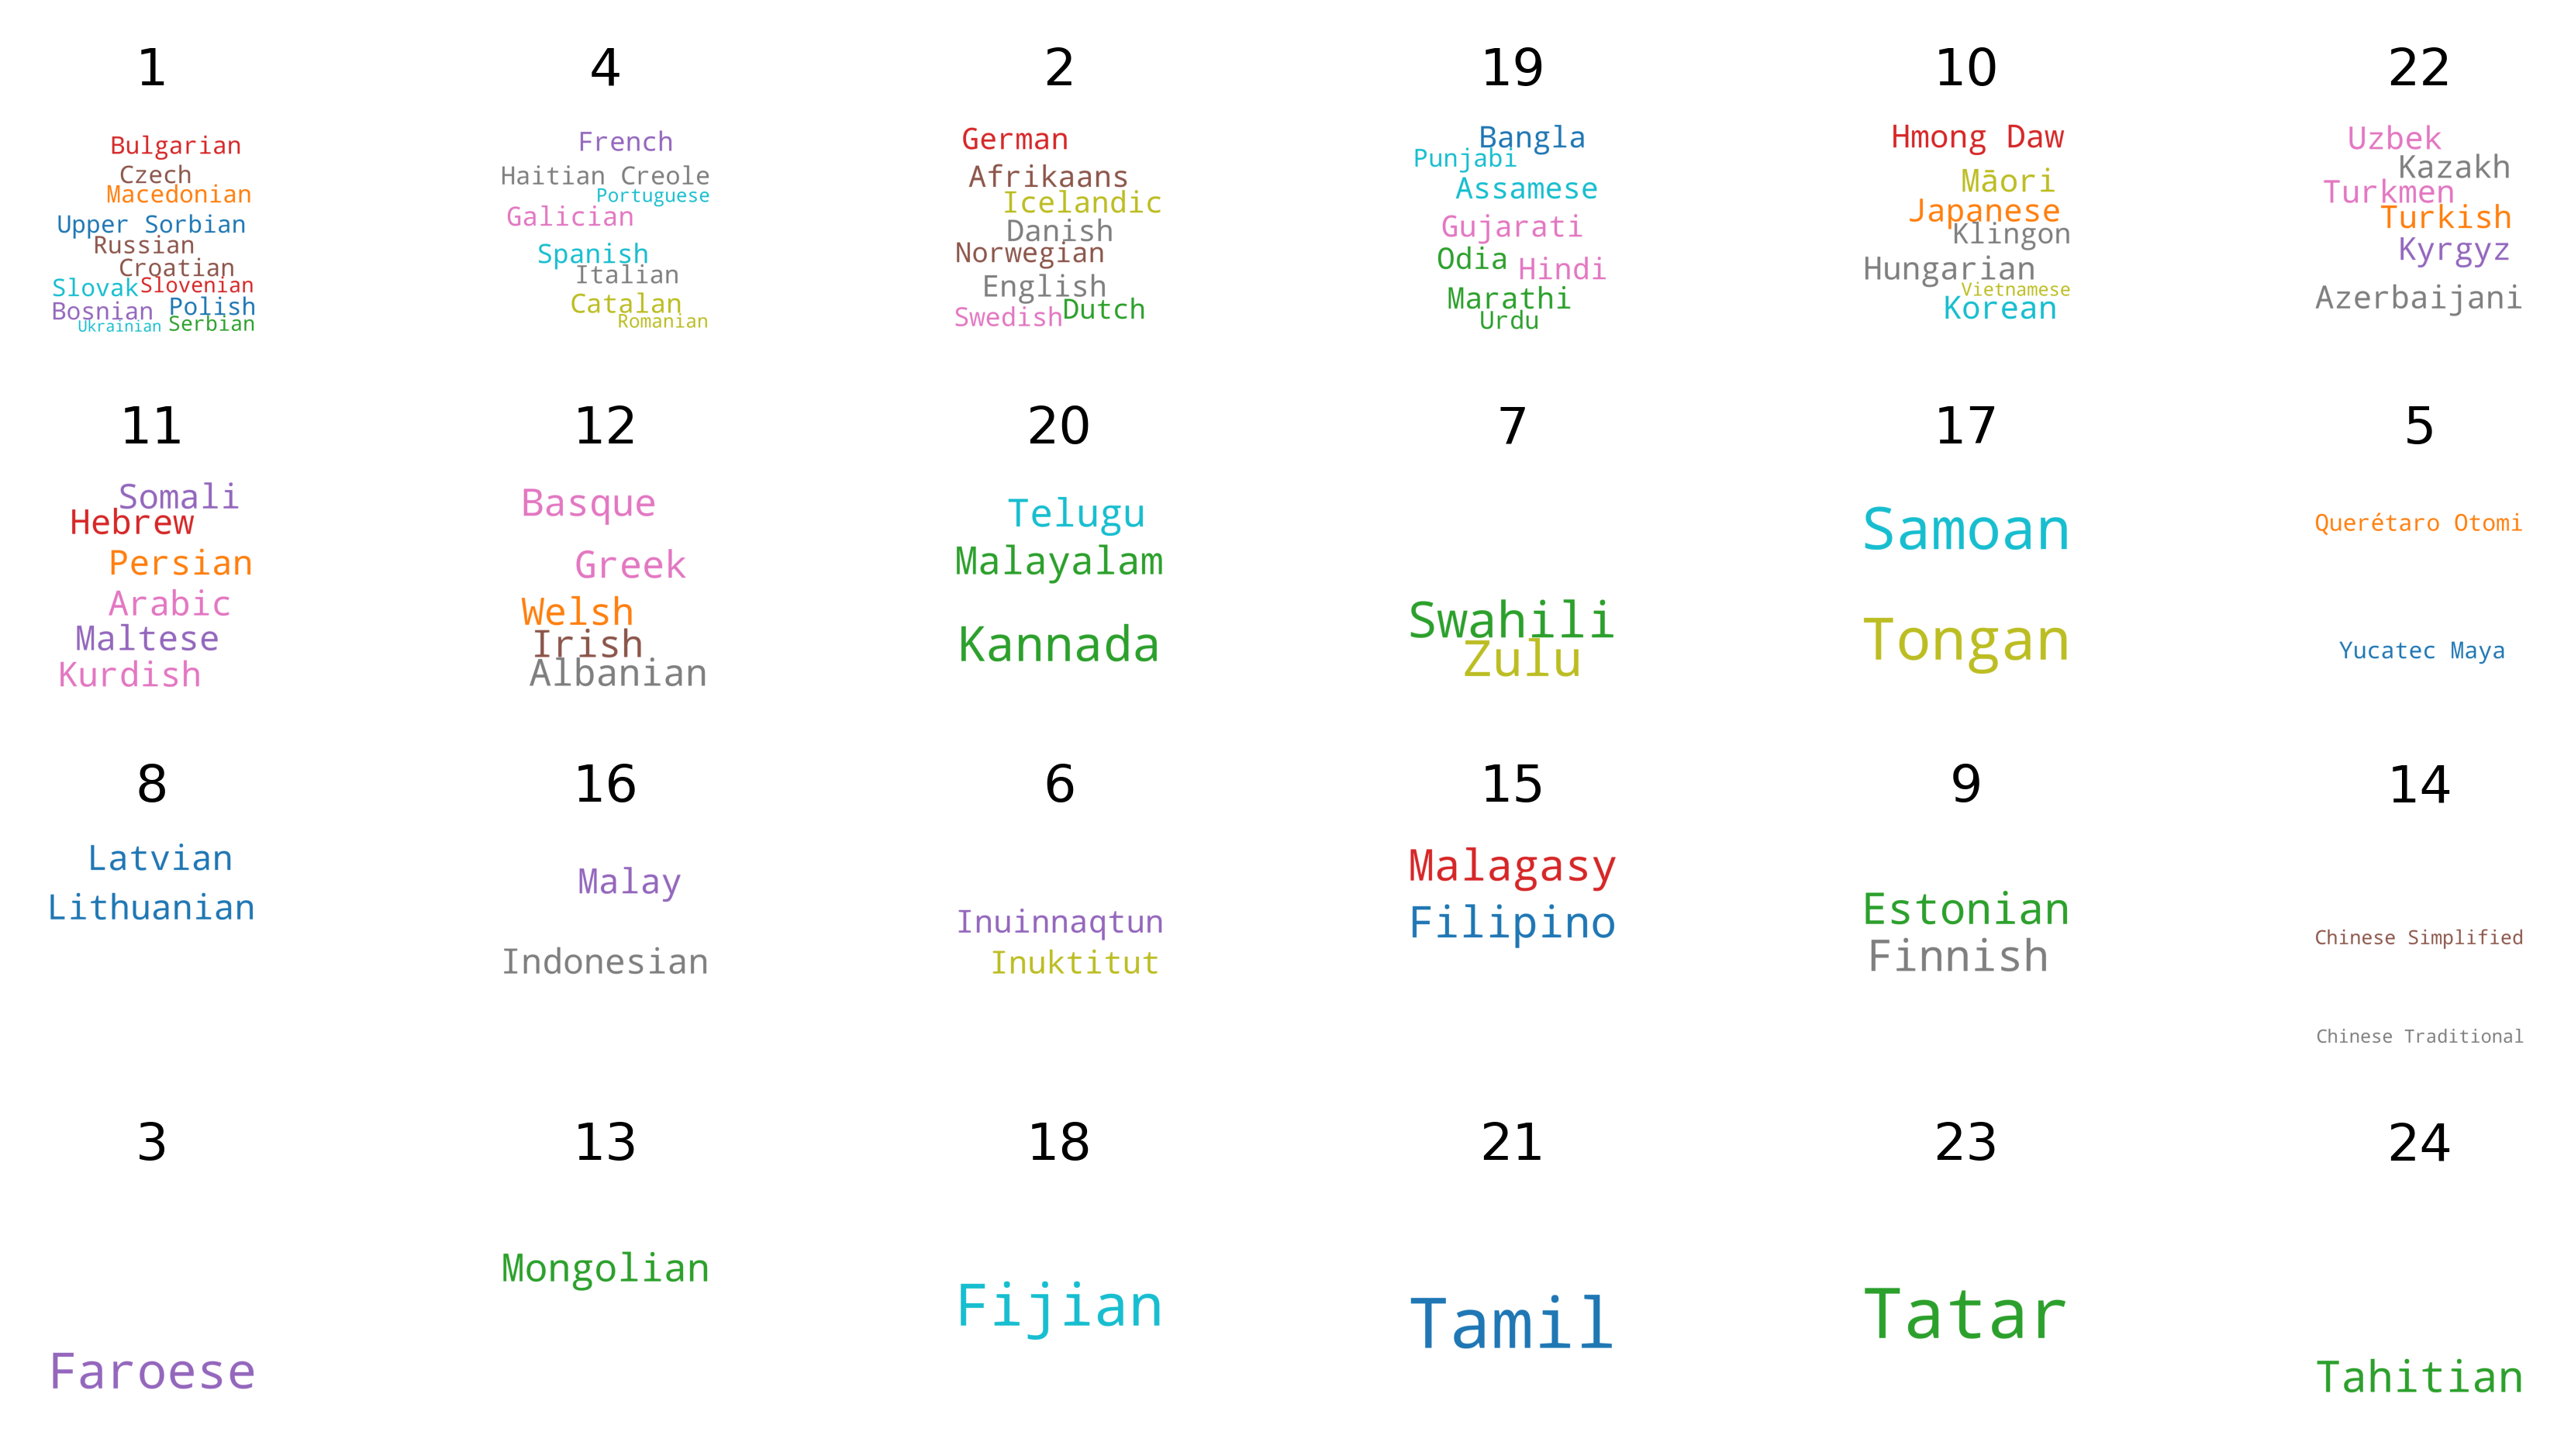

In [16]:
Z = linkage(X, method='ward', optimal_ordering=True)

labels = pd.DataFrame({'name':languages.loc['name'], 'family':fcluster(Z, 24, criterion='maxclust')})

plot_language_groups(labels);

# Calculating distances for the closest words

In [17]:
a = np.vstack(pw_dist_data.apply(sp.spatial.distance.squareform))

@interact
def plot_distance(n=(1, 20, 2)):
    d = sp.spatial.distance.squareform(np.sort(a, axis=0)[:n].sum(axis=0))
    # d = d/d.max()
    plt.imshow(d)
    plt.colorbar()

    delta = 4
    plt.xticks(np.arange(0, len(languages.columns), delta), languages.loc['name'].iloc[::delta], rotation=90);
    plt.yticks(np.arange(0, len(languages.columns), delta), languages.loc['name'].iloc[::delta]);

    plt.title('Total distance to {} closest words'.format(n));

interactive(children=(IntSlider(value=9, description='n', max=20, min=1, step=2), Output()), _dom_classes=('wi…

In [18]:
distances = np.vstack(pw_dist_data.apply(sp.spatial.distance.squareform))

n_clusters = 24

results = []

for num_words in [5, 10, 20, 40, 60, 80, 140, 200]:

    X = np.sort(distances, axis=0)[:num_words].sum(axis=0)  

    for link in ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']:
        
        Z = linkage(X, method=link)

        scores = score_model(fcluster(Z, n_clusters, criterion='maxclust'), languages.loc['sub_family'])

        d = {'num_words':num_words, 'linkage':link}
        d.update(scores)
        results.append(d)

results = pd.DataFrame(results)

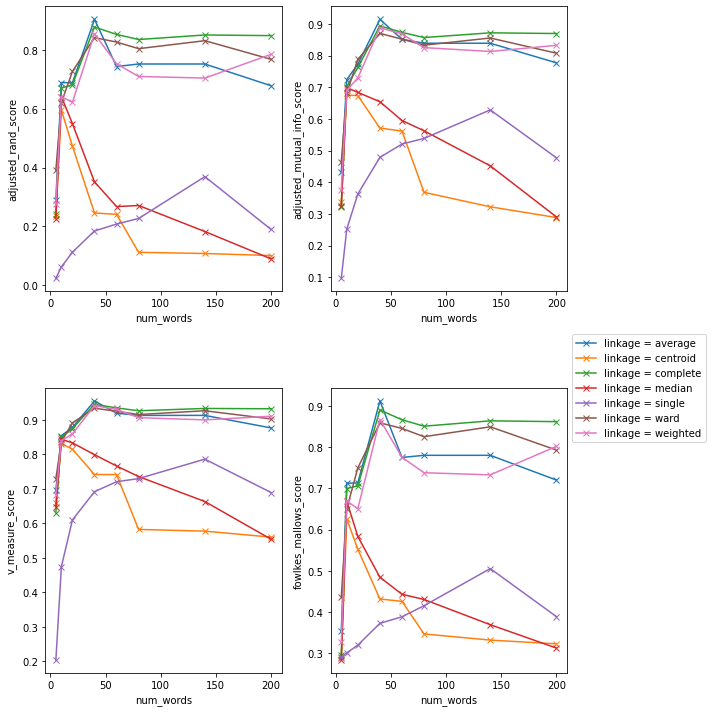

In [19]:
group = results.groupby(['linkage'])

score_name = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'v_measure_score', 'fowlkes_mallows_score']

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, name in enumerate(score_name):
    for key, df in group:
        ax[i//2, i%2].plot(df['num_words'], df[name], label='linkage = {}'.format(key), marker='x')
    
    ax[i//2, i%2].set_xlabel('num_words')
    ax[i//2, i%2].set_ylabel(name)

plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    
plt.tight_layout()

Average, complete, weighted, and Ward linakges perform quite well! Let's check the best model

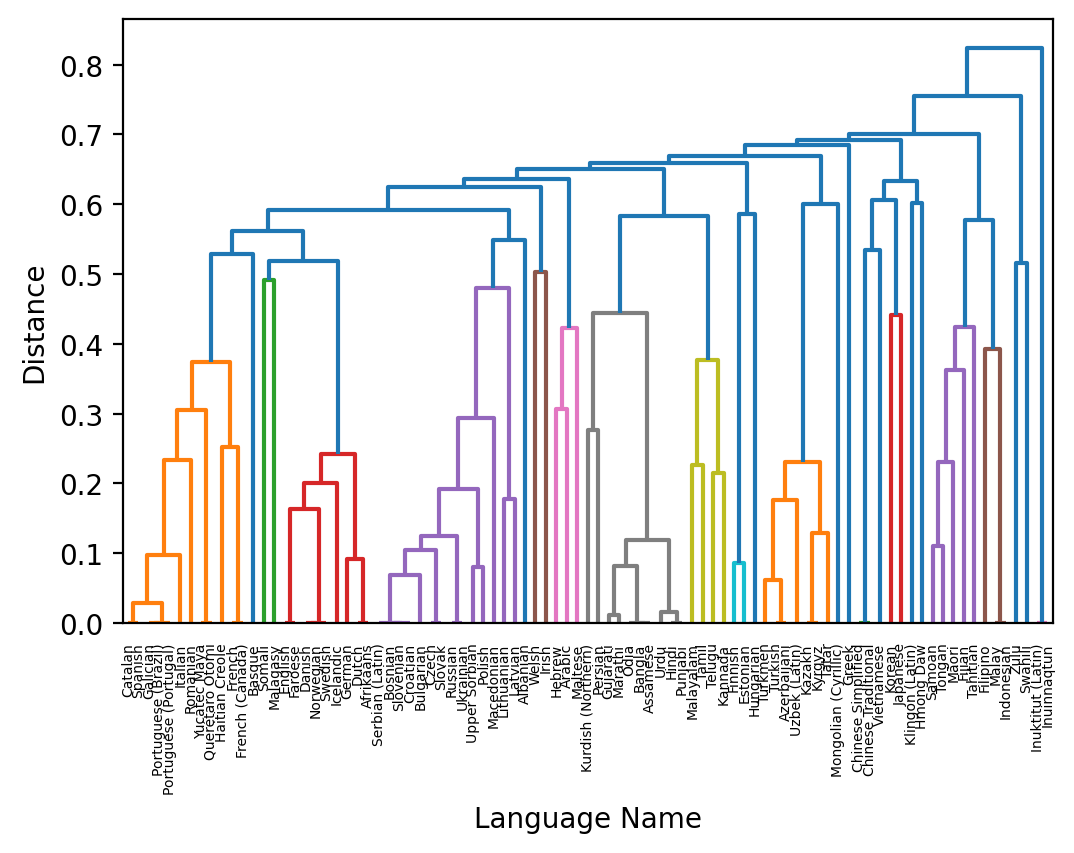

In [20]:
best_params = results.iloc[results['adjusted_rand_score'].argmax()]

distances = np.vstack(pw_dist_data.apply(sp.spatial.distance.squareform))

X = np.sort(distances, axis=0)[:best_params['num_words']].sum(axis=0)
X = X/X.max()

Z = linkage(X, method=best_params['linkage'], optimal_ordering=True)

#Plot tree
fig, ax = plt.subplots(dpi=200)
R = dendrogram(Z, labels=languages.loc['name'], ax=ax, distance_sort='descending', color_threshold=0.51);
plt.xlabel('Language Name')
plt.ylabel('Distance');

# Plot circular tree

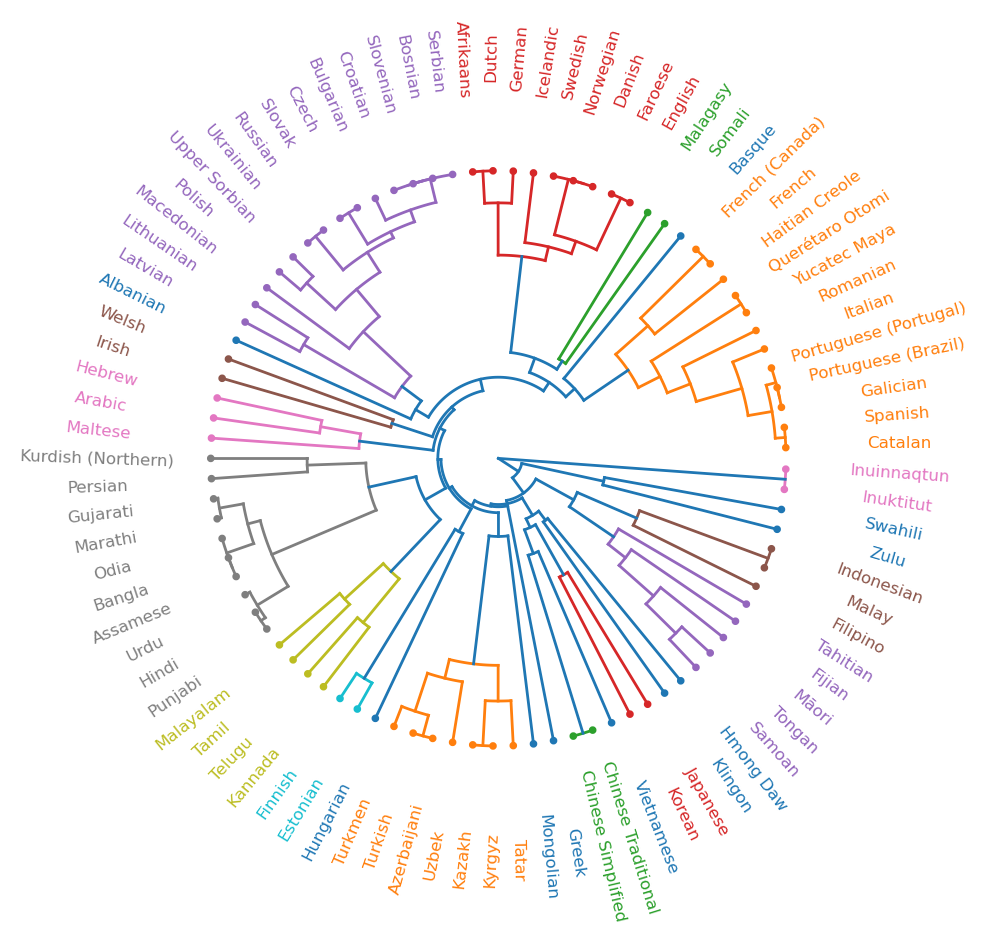

In [25]:
labels=languages.loc['name'].apply(lambda x: x.split(' ')[0] if ('Latin' in x) or ('Cyrillic' in x) else x)

fig, ax = plt.subplots(dpi=200, subplot_kw={'projection': 'polar'})
plot_dendrogram(Z, circular=True, labels=labels, ax=ax, 
                distance_sort='descending', color_threshold=0.51)